In [2]:
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
import decimal
from math import log
import matplotlib.pyplot as plt

In [5]:
dataset = pd.read_csv('apparel-trainval.csv')

In [6]:
df = dataset.sample(60000)
X = df.drop('label', axis = 1)
Y = df['label']
y = pd.get_dummies(Y)

In [7]:
#Standardization of data
X = (X - np.mean(X))/np.std(X)

In [8]:
def sigmoid(s):
    return 1/(1 + np.exp((-s)))

def sigmoid_derv(s):
    return s * (1 - s)

def tanh(s):
    return np.tanh(s)

def tanh_derv(s):
    return 1.0 - np.tanh(s)**2

def ReLU(x):
    return x * (x > 0)

def ReLU_derv(x):
    return 1. * (x > 0)


def softmax(s):
    exps = np.exp(s - np.max(s, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

def cross_entropy(pred, real):
    n_samples = real.shape[0]
    res = pred - real
    return res/n_samples

def error(pred, real):
    n_samples = real.shape[0]
    logp = - np.log(pred[np.arange(n_samples), real.argmax(axis=1)])
    loss = np.sum(logp)/n_samples
    return loss

In [9]:
x_train, x_val, y_train, y_val = train_test_split(X,y, test_size=0.1, random_state=20)

In [10]:
# def exp_normalize(x):
#     b = x.max()
#     y = np.exp(x - b)
#     return y / y.sum()



class MyNN_sigmoid(object):
    def __init__(self, x, y,n):
        self.x = x
        self.y = y
        self.neurons = 200
        self.lr = 0.05
        self.hiddenLayers = n
        self.ip_dim = x.shape[1]
        self.op_dim = y.shape[1]
        self.w = {}
        self.b = {}
        self.z = {}
        self.a = {}
        self.da = {}
        self.dz = {}
        
    def initialization(self):
        self.w[1] = np.random.randn(self.ip_dim, self.neurons)
        self.b[1] = np.zeros((1, self.neurons))
        for i in np.arange(2,self.hiddenLayers+1):
            self.w[i] = np.random.randn(self.neurons, self.neurons)
            self.b[i] = np.zeros((1, self.neurons))
        self.w[self.hiddenLayers+1] = np.random.randn(self.neurons, self.op_dim)
        self.b[self.hiddenLayers+1] = np.zeros((1, self.op_dim))

    def feedforward(self):
        self.z[1] = np.dot(self.x, self.w[1]) + self.b[1]
        self.a[1] = sigmoid(self.z[1])
        #self.a[1] = ReLU(self.z[1])
        #self.a[1] = tanh(self.z[1])
        for i in np.arange(2,self.hiddenLayers+2):
            self.z[i] = np.dot(self.a[i-1], self.w[i]) + self.b[i]
            self.a[i] = sigmoid(self.z[i])
            #self.a[i] = ReLU(self.z[i])
            #self.a[i] = tanh(self.z[i])
        
    def backprop(self):
        loss = error(self.a[self.hiddenLayers+1], self.y)
#         print('Error :', loss)
        self.da[self.hiddenLayers+1] = cross_entropy(self.a[self.hiddenLayers+1], self.y) # w3
        for i in range(self.hiddenLayers,0,-1):
            self.dz[i] = np.dot(self.da[i+1], self.w[i+1].T)
            self.da[i] = self.dz[i] * sigmoid_derv(self.a[i])
#             self.da[i] = self.dz[i] * ReLU_derv(self.a[i])
            #self.da[i] = self.dz[i] * tanh_derv(self.a[i])
       
        self.w[self.hiddenLayers+1] -= self.lr * np.dot(self.a[self.hiddenLayers].T, self.da[self.hiddenLayers+1])
        self.b[self.hiddenLayers+1] -= self.lr * np.sum(self.da[self.hiddenLayers+1], axis=0, keepdims=True)
        for i in range(self.hiddenLayers,1,-1):
            self.w[i] -= self.lr * np.dot(self.a[i-1].T, self.da[i])
            self.b[i] -= self.lr * np.sum(self.da[i], axis=0)
        self.w[1] -= self.lr * np.dot(self.x.T, self.da[1])
        self.b[1] -= self.lr * np.sum(self.da[1], axis=0)

    def predict(self, data):
        self.x = data
        self.feedforward()
        return self.a[self.hiddenLayers+1].argmax()
    
    def get_acc(self,x, y):
        acc = 0
        for i in range(len(x)):
            s = model.predict(x.iloc[i])
            if s == np.argmax(y.iloc[i]):
#             if s == (y.iloc[i]):
                acc +=1
        return acc/len(x)*100
    
    def save_weights(self):
        with open('weights.pickle', 'wb') as handle:
            pickle.dump(self.w, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('bias.pickle', 'wb') as handle:
             pickle.dump(self.b, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_weights(self):
        with open('weights.pickle', 'rb') as handle:
            self.w = pickle.load(handle)
        with open('bias.pickle', 'rb') as handle:
            self.b = pickle.load(handle)

In [11]:
batch_size = 2000
num_of_batches = len(x_train)//batch_size
model = MyNN_sigmoid(x_train.iloc[0:batch_size], np.array(y_train.iloc[0:batch_size]),1)
model.initialization()    
epochs = 100
for x in range(epochs):
    model.feedforward()
    model.backprop()
model.save_weights()

In [12]:
for i in range(1,num_of_batches):
    model = MyNN_sigmoid(x_train.iloc[batch_size*i:batch_size*(i+1)], np.array(y_train.iloc[batch_size*i:batch_size*(i+1)]),1)
    model.load_weights()
    os.remove('weights.pickle')
    os.remove('bias.pickle')
    for x in range(epochs):
        model.feedforward()
        model.backprop()
    model.save_weights()

/home/vagupta/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


In [13]:
print("Using SIGMOID function:-")
# print("Training accuracy : ", model.get_acc(x_train,y_train))
print("Test Accuracy: ", model.get_acc(x_val, y_val))

Using SIGMOID function:-


/home/vagupta/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


Test Accuracy:  76.71666666666667


In [14]:
class MyNN_tan(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.neurons = 200
        self.lr = 0.05
        self.hiddenLayers = 1
        self.ip_dim = x.shape[1]
        self.op_dim = y.shape[1]
        self.w = {}
        self.b = {}
        self.z = {}
        self.a = {}
        self.da = {}
        self.dz = {}
        
    def initialization(self):
        self.w[1] = np.random.randn(self.ip_dim, self.neurons)
        self.b[1] = np.zeros((1, self.neurons))
        for i in np.arange(2,self.hiddenLayers+1):
            self.w[i] = np.random.randn(self.neurons, self.neurons)
            self.b[i] = np.zeros((1, self.neurons))
        self.w[self.hiddenLayers+1] = np.random.randn(self.neurons, self.op_dim)
        self.b[self.hiddenLayers+1] = np.zeros((1, self.op_dim))

    def feedforward(self):
        self.z[1] = np.dot(self.x, self.w[1]) + self.b[1]
#         self.a[1] = sigmoid(self.z[1])
#         self.a[1] = ReLU(self.z[1])
        self.a[1] = tanh(self.z[1])
        for i in np.arange(2,self.hiddenLayers+2):
            self.z[i] = np.dot(self.a[i-1], self.w[i]) + self.b[i]
#             self.a[i] = sigmoid(self.z[i])
#             self.a[i] = ReLU(self.z[i])
            self.a[i] = tanh(self.z[i])
        
    def backprop(self):
        loss = error(self.a[self.hiddenLayers+1], self.y)
#         print('Error :', loss)
        self.da[self.hiddenLayers+1] = cross_entropy(self.a[self.hiddenLayers+1], self.y) # w3
        for i in range(self.hiddenLayers,0,-1):
            self.dz[i] = np.dot(self.da[i+1], self.w[i+1].T)
            #self.da[i] = self.dz[i] * sigmoid_derv(self.a[i])
#             self.da[i] = self.dz[i] * ReLU_derv(self.a[i])
            self.da[i] = self.dz[i] * tanh_derv(self.a[i])
       
        self.w[self.hiddenLayers+1] -= self.lr * np.dot(self.a[self.hiddenLayers].T, self.da[self.hiddenLayers+1])
        self.b[self.hiddenLayers+1] -= self.lr * np.sum(self.da[self.hiddenLayers+1], axis=0, keepdims=True)
        for i in range(self.hiddenLayers,1,-1):
            self.w[i] -= self.lr * np.dot(self.a[i-1].T, self.da[i])
            self.b[i] -= self.lr * np.sum(self.da[i], axis=0)
        self.w[1] -= self.lr * np.dot(self.x.T, self.da[1])
        self.b[1] -= self.lr * np.sum(self.da[1], axis=0)

    def predict(self, data):
        self.x = data
        self.feedforward()
        return self.a[self.hiddenLayers+1].argmax()
    
    def get_acc(self,x, y):
        acc = 0
        for i in range(len(x)):
            s = model.predict(x.iloc[i])
            if s == np.argmax(y.iloc[i]):
#             if s == (y.iloc[i]):
                acc +=1
        return acc/len(x)*100
    
    def save_weights(self):
        with open('weights3.pickle', 'wb') as handle:
            pickle.dump(self.w, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('bias3.pickle', 'wb') as handle:
             pickle.dump(self.b, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_weights(self):
        with open('weights3.pickle', 'rb') as handle:
            self.w = pickle.load(handle)
        with open('bias3.pickle', 'rb') as handle:
            self.b = pickle.load(handle)

In [11]:
batch_size = 2000
num_of_batches = len(x_train)//batch_size
model3 = MyNN_tan(x_train.iloc[0:batch_size], np.array(y_train.iloc[0:batch_size]))
model3.initialization()    
epochs = 200
for x in range(epochs):
    model3.feedforward()
    model3.backprop()
model3.save_weights()

/home/vagupta/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log


In [15]:
for i in range(1,num_of_batches):
    model3 = MyNN_tan(x_train.iloc[batch_size*i:batch_size*(i+1)], np.array(y_train.iloc[batch_size*i:batch_size*(i+1)]))
    model3.load_weights()
    os.remove('weights3.pickle')
    os.remove('bias3.pickle')
    for x in range(epochs):
        model3.feedforward()
        model3.backprop()
    model3.save_weights()

/home/vagupta/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in log


In [16]:
print("Using TAN function:-")
print("Test Accuracy: ", model3.get_acc(x_val, y_val))

Using TAN function:-
Test Accuracy:  76.71666666666667


In [17]:
class MyNN_RELU(object):
    def __init__(self, x, y,n):
        self.x = x
        self.y = y
        self.neurons = 200
        self.lr = 0.05
        self.hiddenLayers = n
        self.ip_dim = x.shape[1]
        self.op_dim = y.shape[1]
        self.w = {}
        self.b = {}
        self.z = {}
        self.a = {}
        self.da = {}
        self.dz = {}
        
    def initialization(self):
        self.w[1] = np.random.randn(self.ip_dim, self.neurons)
        self.b[1] = np.zeros((1, self.neurons))
        for i in np.arange(2,self.hiddenLayers+1):
            self.w[i] = np.random.randn(self.neurons, self.neurons)
            self.b[i] = np.zeros((1, self.neurons))
        self.w[self.hiddenLayers+1] = np.random.randn(self.neurons, self.op_dim)
        self.b[self.hiddenLayers+1] = np.zeros((1, self.op_dim))

    def feedforward(self):
        self.z[1] = np.dot(self.x, self.w[1]) + self.b[1]
#         self.a[1] = sigmoid(self.z[1])
        self.a[1] = ReLU(self.z[1])
        #self.a[1] = tanh(self.z[1])
        for i in np.arange(2,self.hiddenLayers+2):
            self.z[i] = np.dot(self.a[i-1], self.w[i]) + self.b[i]
#             self.a[i] = sigmoid(self.z[i])
            self.a[i] = ReLU(self.z[i])
            #self.a[i] = tanh(self.z[i])
        
    def backprop(self):
        loss = error(self.a[self.hiddenLayers+1], self.y)
#         print('Error :', loss)
        self.da[self.hiddenLayers+1] = cross_entropy(self.a[self.hiddenLayers+1], self.y) # w3
        for i in range(self.hiddenLayers,0,-1):
            self.dz[i] = np.dot(self.da[i+1], self.w[i+1].T)
            #self.da[i] = self.dz[i] * sigmoid_derv(self.a[i])
            self.da[i] = self.dz[i] * ReLU_derv(self.a[i])
            #self.da[i] = self.dz[i] * tanh_derv(self.a[i])
       
        self.w[self.hiddenLayers+1] -= self.lr * np.dot(self.a[self.hiddenLayers].T, self.da[self.hiddenLayers+1])
        self.b[self.hiddenLayers+1] -= self.lr * np.sum(self.da[self.hiddenLayers+1], axis=0, keepdims=True)
        for i in range(self.hiddenLayers,1,-1):
            self.w[i] -= self.lr * np.dot(self.a[i-1].T, self.da[i])
            self.b[i] -= self.lr * np.sum(self.da[i], axis=0)
        self.w[1] -= self.lr * np.dot(self.x.T, self.da[1])
        self.b[1] -= self.lr * np.sum(self.da[1], axis=0)

    def predict(self, data):
        self.x = data
        self.feedforward()
        return self.a[self.hiddenLayers+1].argmax()
    
    def get_acc(self,x, y):
        acc = 0
        for i in range(len(x)):
            s = model.predict(x.iloc[i])
            if s == np.argmax(y.iloc[i]):
#             if s == (y.iloc[i]):
                acc +=1
        return acc/len(x)*100
    
    def save_weights(self):
        with open('weights2.pickle', 'wb') as handle:
            pickle.dump(self.w, handle, protocol=pickle.HIGHEST_PROTOCOL)
        with open('bias2.pickle', 'wb') as handle:
             pickle.dump(self.b, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_weights(self):
        with open('weights2.pickle', 'rb') as handle:
            self.w = pickle.load(handle)
        with open('bias2.pickle', 'rb') as handle:
            self.b = pickle.load(handle)

In [19]:
batch_size = 2000
num_of_batches = len(x_train)//batch_size
model2 = MyNN_RELU(x_train.iloc[0:batch_size], np.array(y_train.iloc[0:batch_size]),1)
model2.initialization()    
epochs = 200
for x in range(epochs):
    model2.feedforward()
    model2.backprop()
model2.save_weights()

/home/vagupta/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/home/vagupta/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply
/home/vagupta/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/vagupta/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/home/vagupta/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


In [20]:
for i in range(1,num_of_batches):
    model2 = MyNN_RELU(x_train.iloc[batch_size*i:batch_size*(i+1)], np.array(y_train.iloc[batch_size*i:batch_size*(i+1)]),1)
    model2.load_weights()
    os.remove('weights2.pickle')
    os.remove('bias2.pickle')
    for x in range(epochs):
        model2.feedforward()
        model2.backprop()
    model2.save_weights()

/home/vagupta/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/home/vagupta/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


In [21]:
print("Using RELU function:-")
print("Test Accuracy: ", model2.get_acc(x_val, y_val))

Using RELU function:-
Test Accuracy:  76.71666666666667


In [22]:
test_dataset = pd.read_csv('apparel-test.csv')

In [24]:
test_dataset =(test_dataset - np.mean(test_dataset))/np.std(test_dataset)

In [26]:
predict = []
for i in range(len(test_dataset)):
    predict.append(model.predict(np.array(test_dataset.iloc[i])))

In [27]:
pd.DataFrame(list(predict)).to_csv('2018201003_prediction.csv',index=False)

Text(0, 0.5, 'Prediction Loss')

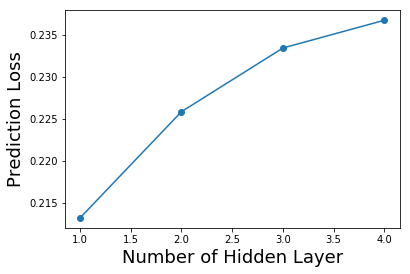

In [8]:
# from pylab import 
# import matplotlib
# import matplotlib.pyplot as plt

fig, ax = plt.subplots()

numHiddenLayerList=[1,2,3,4]
accurList=[1-.7868,1-.774166,1-.7666,1-.7633]

ax.plot(numHiddenLayerList, accurList,marker='o')
ax.set_xlabel("Number of Hidden Layer", fontsize=18)
ax.set_ylabel("Prediction Loss", fontsize=18)

Text(0, 0.5, 'Error')

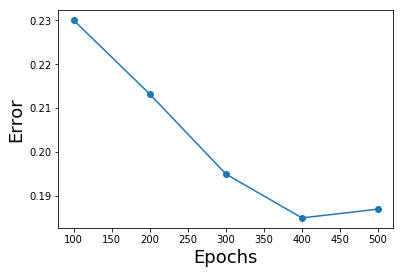

In [3]:
fig, ax = plt.subplots()

numHiddenLayerList=[100,200,300,400,500]
accurList=[1-0.77,1-.7868,1-.805,1-0.815,1-0.813]

ax.plot(numHiddenLayerList, accurList,marker='o')
ax.set_xlabel("Epochs", fontsize=18)
ax.set_ylabel("Error", fontsize=18)